Let's start by importing some modules :


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

and let's define the global variables of the notebook :


In [2]:
vw = 1. # Wall velocity in unity of c
cs = np.sqrt(1./3.) # Sound speed 
alpha = 100. # Temperature in Gev at the GW production
g_star = 100.
k_phi = 1.
K = (k_phi*alpha)/(1. + alpha)
h_small = .678
H_0 = 2.2*10**(-18) # Hubble constant today in Hz
Tau = 3*365*24*60*60 #Time of the mission in seconds

We may now start to define the functions needed to estimate the executions variables :

In [3]:
# Function for the estimation of the frequency of the peak of the sound wave

def Find_fenv(norm_beta, T_star):
    return (16.5*(10.**(-6.))*(0.62/(1.8 - 0.1*vw + vw*vw))*norm_beta*(T_star/100.)*((g_star/100.)**(1./6.))) # Hz

In [4]:
# Function for the estimation of the spectral shape of the sound wave 

def SpectralShapeEnv(freq, norm_beta, T_star):
    f_env = Find_fenv(norm_beta, T_star)
    return ((3.8*((freq/f_env)**(2.8)))/(1. + 2.8*((freq/f_env)**3.8)))

Hence we may define the sound waves spectral density :

In [5]:
def OmegaEnv(freq, norm_beta, T_star):
           
    return (1.67*(10.**(-5.))*(1./(norm_beta**2))*((100./g_star)**(1./3.))*((0.11*(vw**3.))/(0.42 + (vw**2.)))*(K**2.)*SpectralShapeEnv(freq,norm_beta,T_star)) 
        

In the last two functions, **norm_beta** is equal to $\beta / H_{*}$, all the local variables for this simulation would be setted to the following values : 

Furthermore, we'll need an integration function for the SNR, we will use one function for finding the index within the window and one function that will integrate using the trapeze method :

In [6]:
def SNR(fid_start,fid_end):
    IntVal1 = 0.
    IntVal2 = 0.
    IntVal3 = 0.
    for i in range(fid_start, fid_end, 1):
        IntVal1 += (df.Frequency[i+1] - df.Frequency[i])*((df.EnvSpectrum[i])/(df.First_Sensitivity[i]))**2.
        IntVal2 += (df.Frequency[i+1] - df.Frequency[i])*((df.EnvSpectrum[i])/(df.Second_Sensitivity[i]))**2.
        IntVal3 += (df.Frequency[i+1] - df.Frequency[i])*((df.EnvSpectrum[i])/(df.Third_Sensitivity[i]))**2.
    SNR1 = np.sqrt(Tau*IntVal1)
    SNR2 = np.sqrt(Tau*IntVal2)
    SNR3 = np.sqrt(Tau*IntVal3)
    return SNR1,SNR2,SNR3

The variables, for the trial run would be set to :

In [7]:
T_star = 250. 
norm_beta = 250. 

Let's load the sensitivity curves of the detectors:


In [8]:
df1 = pd.read_csv('S_h_scird.txt', sep=" ", header = None)
df2 = pd.read_csv('S_h_scird_deg1.txt', sep=" ", header = None)
df3 = pd.read_csv('S_h_scird_deg2.txt', sep=" ", header = None)

And let's estimate the amplitude of the sensitivity curves :

In [9]:
df1['Sensitivity'] = ((4*np.pi**2)/(3*H_0**2))*df1[6]*(df1[3])**3
df2['Sensitivity'] = ((4*np.pi**2)/(3*H_0**2))*df2[6]*(df2[3])**3
df3['Sensitivity'] = ((4*np.pi**2)/(3*H_0**2))*df3[6]*(df3[3])**3

Now we may define the complete dataframe as :

In [10]:
d = {'Frequency' : df1[3], 'First_Sensitivity' : df1['Sensitivity'], 'Second_Sensitivity' : df2['Sensitivity'], 'Third_Sensitivity' : df3['Sensitivity']}
df = pd.DataFrame(data = d)

Hence the Spectrum of the sound waves may be added to the dataframe as :

In [11]:
df['EnvSpectrum'] = OmegaEnv(df['Frequency'], norm_beta, T_star)

Let's try to plot the curves :

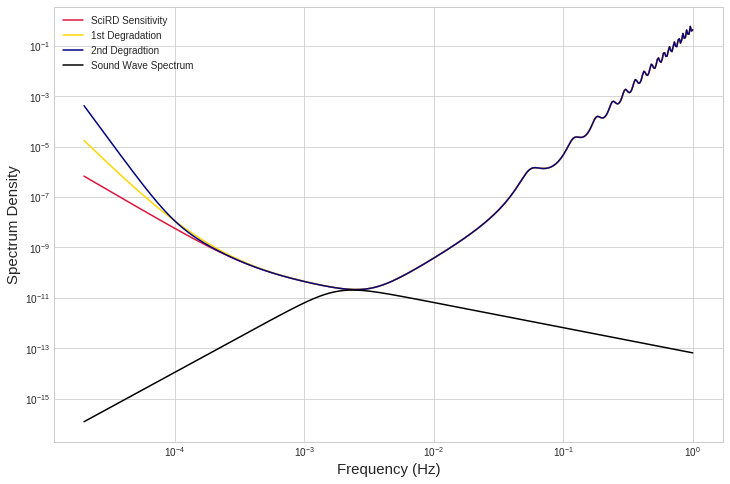

In [12]:
fig = plt.figure(figsize=[12,8])
ax = plt.axes()
ax.loglog()
ax.plot(df.Frequency, df.First_Sensitivity, color = 'crimson', label = 'SciRD Sensitivity')
ax.plot(df.Frequency, df.Second_Sensitivity, color = 'gold', label = '1st Degradation')
ax.plot(df.Frequency, df.Third_Sensitivity, color = 'navy', label = '2nd Degradtion')
ax.plot(df.Frequency, df.EnvSpectrum, color = 'black', label = 'Sound Wave Spectrum')
ax.set_xlabel('Frequency (Hz)', fontsize = 15)
ax.set_ylabel('Spectrum Density', fontsize = 15)
ax.legend()

Hence the SNR for the different sensitivities are given by :

In [13]:
# Uncomment the next line for an SNR within the Window
#SNR1, SNR2, SNR3 = SNR(fid_start,fid_end)
# Uncomment the next line for an SNR over all the frequency range 
SNR1, SNR2, SNR3 = SNR(0,len(df.Frequency) - 1)
print("The SNR with the first sensitivity is :", SNR1)
print("The SNR with the second sensitivity is :", SNR2)
print("The SNR with the third sensitivity is :", SNR3)

The SNR with the first sensitivity is : 413.70445517131844
The SNR with the second sensitivity is : 413.2317082570268
The SNR with the third sensitivity is : 413.7031069558001


We now have to show as the SNR behaves in function of the spanned variables, let's define some result matrix :

In [14]:
Z1 = np.zeros((100,100))
Z2 = np.zeros((100,100))
Z3 = np.zeros((100,100))
R1 = np.zeros((100,100))
R2 = np.zeros((100,100))
R3 = np.zeros((100,100))

Let's also define the span of the two variables as :

In [15]:
log_span_Tstar = np.linspace(0,4,100)
span_Tstar = 1.*10.**(log_span_Tstar)
log_span_beta = np.linspace(0,4,100)
span_beta = 1.*10**(log_span_beta)
X, Y = np.meshgrid(span_Tstar, span_beta)

We just have to run over the simulation over the values :

In [16]:
for i in range(100):
    for j in range(100):
        df['EnvSpectrum'] = OmegaEnv(df['Frequency'], Y[j][i], X[j][i])
        
        #Uncomment this section for an SNR analysis within the window
        
        #f_sw = Find_fsw(X[j][i], Y[j][i])
        #fid_start,fid_end =IntExtremes(f_sw,window)
        #Z1[j][i],Z2[j][i],Z3[j][i] = SNR(fid_start,fid_end)
        
        #Uncomment this section for an SNR analysis in the whole Frequency range
        
        Z1[j][i],Z2[j][i],Z3[j][i] = SNR(0, len(df.Frequency) - 1)     
        R1[j][i] = Z2[j][i]/Z1[j][i]
        R2[j][i] = Z3[j][i]/Z1[j][i]
        R3[j][i] = Z3[j][i]/Z2[j][i]
        

We just have to plot the results for the 3 different sensitivity curves :

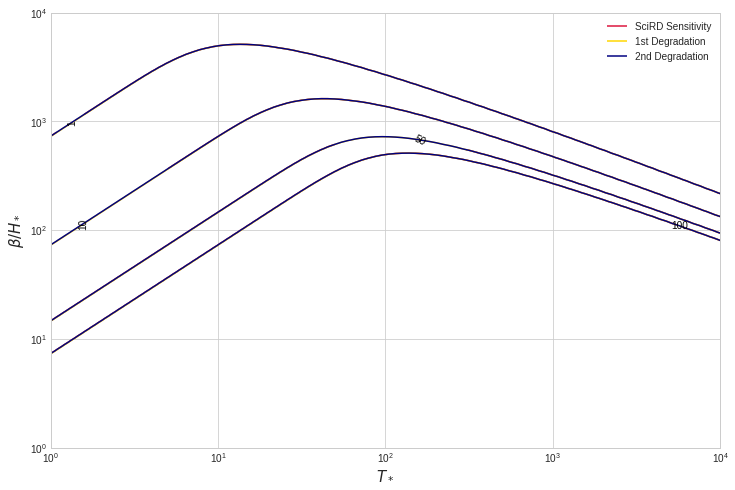

In [17]:
# Uncomment this block for a single plot of the 3 contour line

fig, ax = plt.subplots(figsize = [12,8])
c1 = ax.contour(X, Y, Z1, levels=[1, 10,50,100], colors = 'crimson');
c2 = ax.contour(X, Y, Z2, levels=[1, 10,50,100], colors = 'gold');
c3 = ax.contour(X, Y, Z3, levels=[1, 10,50,100], colors='navy');
ax.clabel(c1, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
lines = [ c1.collections[0], c2.collections[0], c3.collections[0]]
labels = ['SciRD Sensitivity','1st Degradation','2nd Degradation']
ax.set_xlabel(r'$T_*$', fontsize = 15)
ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

ax.loglog()
plt.legend(lines, labels)

fig.savefig('ZoomFOMEnv.png', dpi = 500)


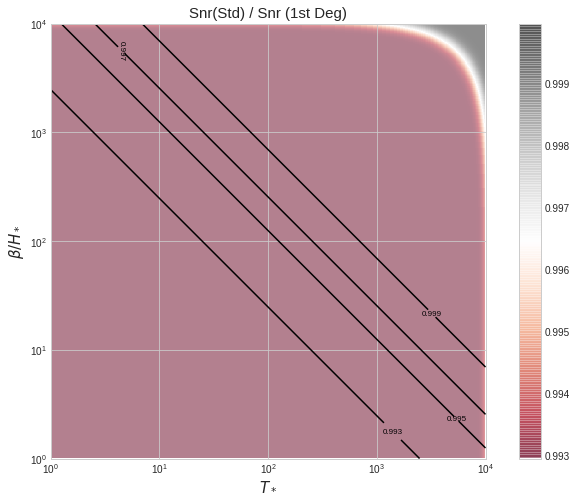

In [68]:
#Plot the ratio among the different SNR curves, Std vs 1st degradation

fig, ax = plt.subplots(figsize = [12,8])
contours = ax.contour(X, Y, R1, levels=[0.993, 0.995, 0.997, 0.999], colors='black')
plt.clabel(contours, inline=True, fontsize=8)
ax.set_title('Snr(Std) / Snr (1st Deg)', fontsize = 15)
ax.set_xlabel(r'$T_*$', fontsize = 15)
ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)
ax.loglog()

plt.imshow(R1, extent=[1, 10000, 1, 10000], origin='lower',
           cmap='RdGy', alpha=0.5)
plt.colorbar();

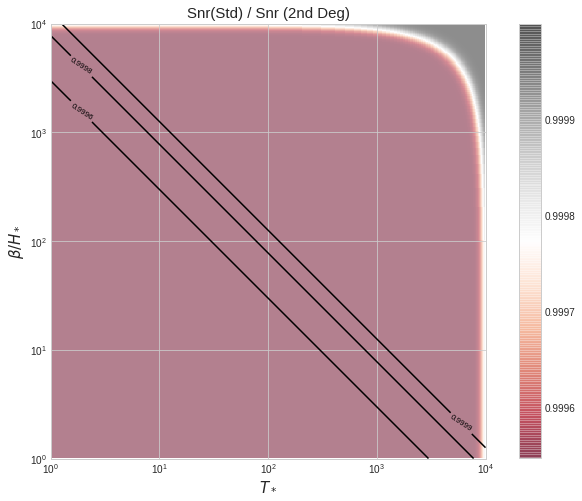

In [69]:
#Plot the ratio among the different SNR curves, Std vs 2nd degradation

fig, ax = plt.subplots(figsize = [12,8])
contours = ax.contour(X, Y, R2, levels=[0.9996,0.9998,0.9999], colors='black')
ax.set_title('Snr(Std) / Snr (2nd Deg)', fontsize = 15)
ax.set_xlabel(r'$T_*$', fontsize = 15)
ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)
ax.loglog()

plt.clabel(contours, inline=True, fontsize=8, fmt = '%1.4f')

plt.imshow(R2, extent=[1, 10000, 1, 10000], origin='lower',
           cmap='RdGy', alpha=0.5)
plt.colorbar();

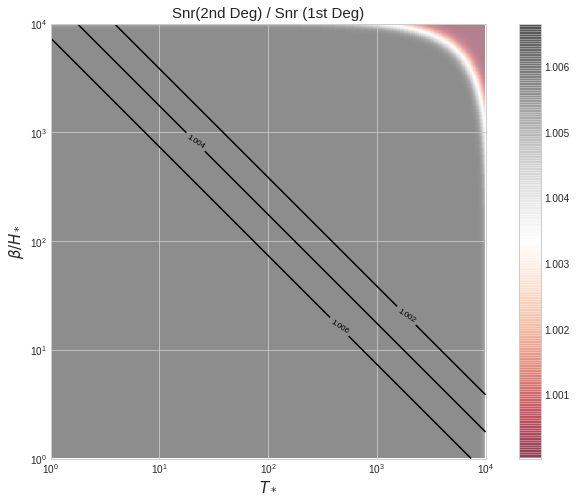

In [70]:
#Plot the ratio among the different SNR curves, 2nd degradation vs 1st Degradation

fig, ax = plt.subplots(figsize = [12,8])
contours = ax.contour(X, Y, R3, levels=[1.002, 1.004, 1.006], colors='black')
ax.set_title('Snr(2nd Deg) / Snr (1st Deg)', fontsize = 15)
ax.set_xlabel(r'$T_*$', fontsize = 15)
ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)
ax.loglog()

plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(R3, extent=[1, 10000, 1, 10000], origin='lower',
           cmap='RdGy', alpha=0.5)
plt.colorbar();

In [18]:
# Uncomment the next 3 block for the single plots

#fig, ax = plt.subplots(figsize = [12,8])
#c1 = ax.contour(X, Y, Z1, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c1, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [ c1.collections[0]]
#labels = ['SciRD Sensitivity']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)

In [19]:
#fig, ax = plt.subplots(figsize = [12,8])
#c2 = ax.contour(X, Y, Z2, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c2, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [c2.collections[0]]
#labels = ['1st Degradation']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)

In [20]:
#fig, ax = plt.subplots(figsize = [12,8])
#c3 = ax.contour(X, Y, Z3, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c3, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [c3.collections[0]]
#labels = ['2nd Degradation']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)